# Image Classification for Coffee or Donuts

Is the given image a coffee photo, or a donut?
In this demo notebook we build a simple deep neural network to classify an image as one of the following:
- coffee
- mug
- donut


# Setup

In [112]:
credentials = {
  "bucket": "fffff",
  "access_key_id": "fff",
  "secret_access_key": "ffff",
  "endpoint_url": "fff"
}

## Install Prerequisites

We use Keras/Tensorflow to build the classification model, and visualize the process with matplotlib.

In [3]:
!pip install tensorflow==1.15 ibm-cos-sdk==2.6

     |████████████████████████████████| 412.3MB 25kB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 512kB 38.1MB/s 
     |████████████████████████████████| 3.8MB 32.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 768kB 29.8MB/s 
     |████████████████████████████████| 225kB 41.8MB/s 
     |████████████████████████████████| 552kB 31.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.6.0-py2.py3-none-any.whl size=72545 sha256=5cc3f0a62490988bd9d012671d7baf00859e5e661666a3ea2b5918b98b8b855a
  Stored in directory: /root/.cache/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=f2b088ccb641e941e677370cb4db5220f7f3bdf5d7952e8cf49fb753ef6890f5
  Stored in directory: /root/.c

In [5]:
# Import required libraries
import os
import uuid
import shutil
import json
#from botocore.client import Config
import ibm_boto3
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Read The Data

Here we build simple wrapper functions to read in the data from our cloud object storage buckets and extract it.

A download function from IBM Cloud

In [9]:
def download_file_cos(credentials, local_file_name, key): 
    '''
    Wrapper function to download a file from cloud object storage using the
    credential dict provided and loading it into memory
    '''
    cos = ibm_boto3.client(
        service_name='s3',
        aws_access_key_id=credentials['access_key_id'],
        aws_secret_access_key=credentials['secret_access_key'],
        endpoint_url=credentials['endpoint_url'])
    try:
        res=cos.download_file(Bucket=credentials['bucket'], Key=key, Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def get_annotations(credentials): 
    cos = ibm_boto3.client(
        service_name='s3',
        aws_access_key_id=credentials['access_key_id'],
        aws_secret_access_key=credentials['secret_access_key'],
        endpoint_url=credentials['endpoint_url'])
    try:
        return json.loads(cos.get_object(Bucket=credentials['bucket'], Key='_annotations.json')['Body'].read())
    except Exception as e:
        print(Exception, e)

In [13]:
base_path = 'data'
if os.path.exists(base_path) and os.path.isdir(base_path):
    shutil.rmtree(base_path)
os.makedirs(base_path, exist_ok=True)

annotations = get_annotations(credentials)

for i, image in enumerate(annotations['annotations'].keys()):
    label = annotations['annotations'][image][0]['label']
    os.makedirs(os.path.join(base_path, label), exist_ok=True)
    _, extension = os.path.splitext(image)
    local_path = os.path.join(base_path, label, str(uuid.uuid4()) + extension)
    download_file_cos(credentials, local_path, image)

File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Dow

In [17]:
!ls data


eb1compress  healthyv1	lb1compress


## Build the Model

We start with a [MobileNetV2](https://arxiv.org/abs/1801.04381) architecture as the backbone [pretrained feature extractor](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet). We then add a couple of dense layers and a softmax layer to perfom the classification. We freeze the MobileNetV2 backbone with weights trained on ImageNet dataset and only train the dense layers and softmax layer that we have added.

In [22]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 1
x=tf.keras.layers.Dense(256,activation='relu')(x) #dense layer 2
preds=tf.keras.layers.Dense(3,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=base_model.input,outputs=preds)


/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [23]:
#Freeze layers from MobileNetV2 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

In [24]:
#Prepare the training dataset as a data generator object
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 326 images belonging to 3 classes.


### Using Adam, categorical_crossentropy and accuracy as optimization method, loss function and metrics, respectively

In [26]:
# Build the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
____________________________________________________________________________________________

## Train the model

In [27]:
from tensorflow import set_random_seed
set_random_seed(2)
step_size_train=5
log_file = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=4)

Epoch 1/4
5/5 [==============================] - 8s 2s/step - loss: 1.3655 - acc: 0.3200
Epoch 2/4
5/5 [==============================] - 6s 1s/step - loss: 0.6366 - acc: 0.6800
Epoch 3/4
5/5 [==============================] - 6s 1s/step - loss: 0.5123 - acc: 0.7400
Epoch 4/4
5/5 [==============================] - 5s 1s/step - loss: 0.3411 - acc: 0.8600


## Figure of Training Loss and Accuracy

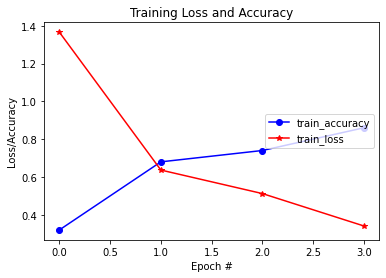

In [28]:
# Model accuracy and loss vs epoch
plt.plot(log_file.history['acc'], '-bo', label="train_accuracy")
plt.plot(log_file.history['loss'], '-r*', label="train_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

## Model Performance

Here we perform inference on some sample data points to determine the performance of the model

In [29]:
# Mapping labels 
label_map = (train_generator.class_indices)

In [39]:
label_map

{'eb1compress': 0, 'healthyv1': 1, 'lb1compress': 2}

In [40]:
# Creating a sample inference function
def prediction(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    preds = model.predict(x)
    #print('Predictions', preds)
    
    for pred, value in label_map.items():    
        if value == np.argmax(preds):
            print('Predicted class is:', pred)
            print('With a confidence score of: ', np.max(preds))
    
    return np.argmax(preds)

In [41]:
coffee_url = 'https://i5.walmartimages.com/asr/559143bb-3fd0-41b0-8358-fb0f74c41f8d_1.61dbeaff765619bbba67d4e519174932.jpeg'
mug_url = 'https://cdn.cnn.com/cnnnext/dam/assets/150929101049-black-coffee-stock-super-tease.jpg'
donut_url = 'https://i.ytimg.com/vi/gevpzxRxec4/maxresdefault.jpg'
!wget {coffee_url} -O Coffee.jpg 
!wget {mug_url} -O Mug.jpg
!wget {donut_url} -O Donut.jpg

--2021-05-16 12:33:29--  https://i5.walmartimages.com/asr/559143bb-3fd0-41b0-8358-fb0f74c41f8d_1.61dbeaff765619bbba67d4e519174932.jpeg
Resolving i5.walmartimages.com (i5.walmartimages.com)... 151.101.1.74, 151.101.65.74, 151.101.129.74, ...
Connecting to i5.walmartimages.com (i5.walmartimages.com)|151.101.1.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 828048 (809K) [image/jpeg]
Saving to: ‘Coffee.jpg’

Coffee.jpg          100%[===================>] 808.64K  --.-KB/s    in 0.05s   

2021-05-16 12:33:29 (14.5 MB/s) - ‘Coffee.jpg’ saved [828048/828048]

--2021-05-16 12:33:29--  https://cdn.cnn.com/cnnnext/dam/assets/150929101049-black-coffee-stock-super-tease.jpg
Resolving cdn.cnn.com (cdn.cnn.com)... 184.25.188.181, 2600:1408:7400:18c::3134, 2600:1408:7400:1a4::3134
Connecting to cdn.cnn.com (cdn.cnn.com)|184.25.188.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132570 (129K) [image/jpeg]
Saving to: ‘Mug.jpg’

Mug.jpg        

# !picture{https://drive.google.com/file/d/1RoPiraC1x7rpTIsuTSI5M17lnMkxjTlO/view?usp=sharing} 

In [103]:
!ls

Coffee.jpg  data  Donut.jpg  Mug.jpg  potato.jpg  sample_data


In [104]:
!dir

Coffee.jpg  data  Donut.jpg  Mug.jpg  potato.jpg  sample_data


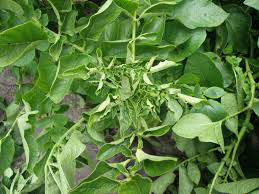

In [107]:
image = Image.open("potato.jpg")
image




In [108]:
#performing inference on above image
prediction('potato.jpg', model)

Predicted class is: eb1compress
With a confidence score of:  0.39136726


0

In [125]:
#model.summary()
# my_model directory
!mkdir -p saved_model
model.save('saved_model/my_model') 


In [126]:
!dir

Coffee.jpg  data  Donut.jpg  Mug.jpg  potato.jpg  sample_data  saved_model


In [127]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
saved_model/my_model


In [133]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
#new_model.summary()
model.save('may16_model.h5') 

In [136]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('may16_model.h5')

# Show the model architecture
#new_model.summary()
prediction('potato.jpg', new_model)

Predicted class is: eb1compress
With a confidence score of:  0.39136726


0

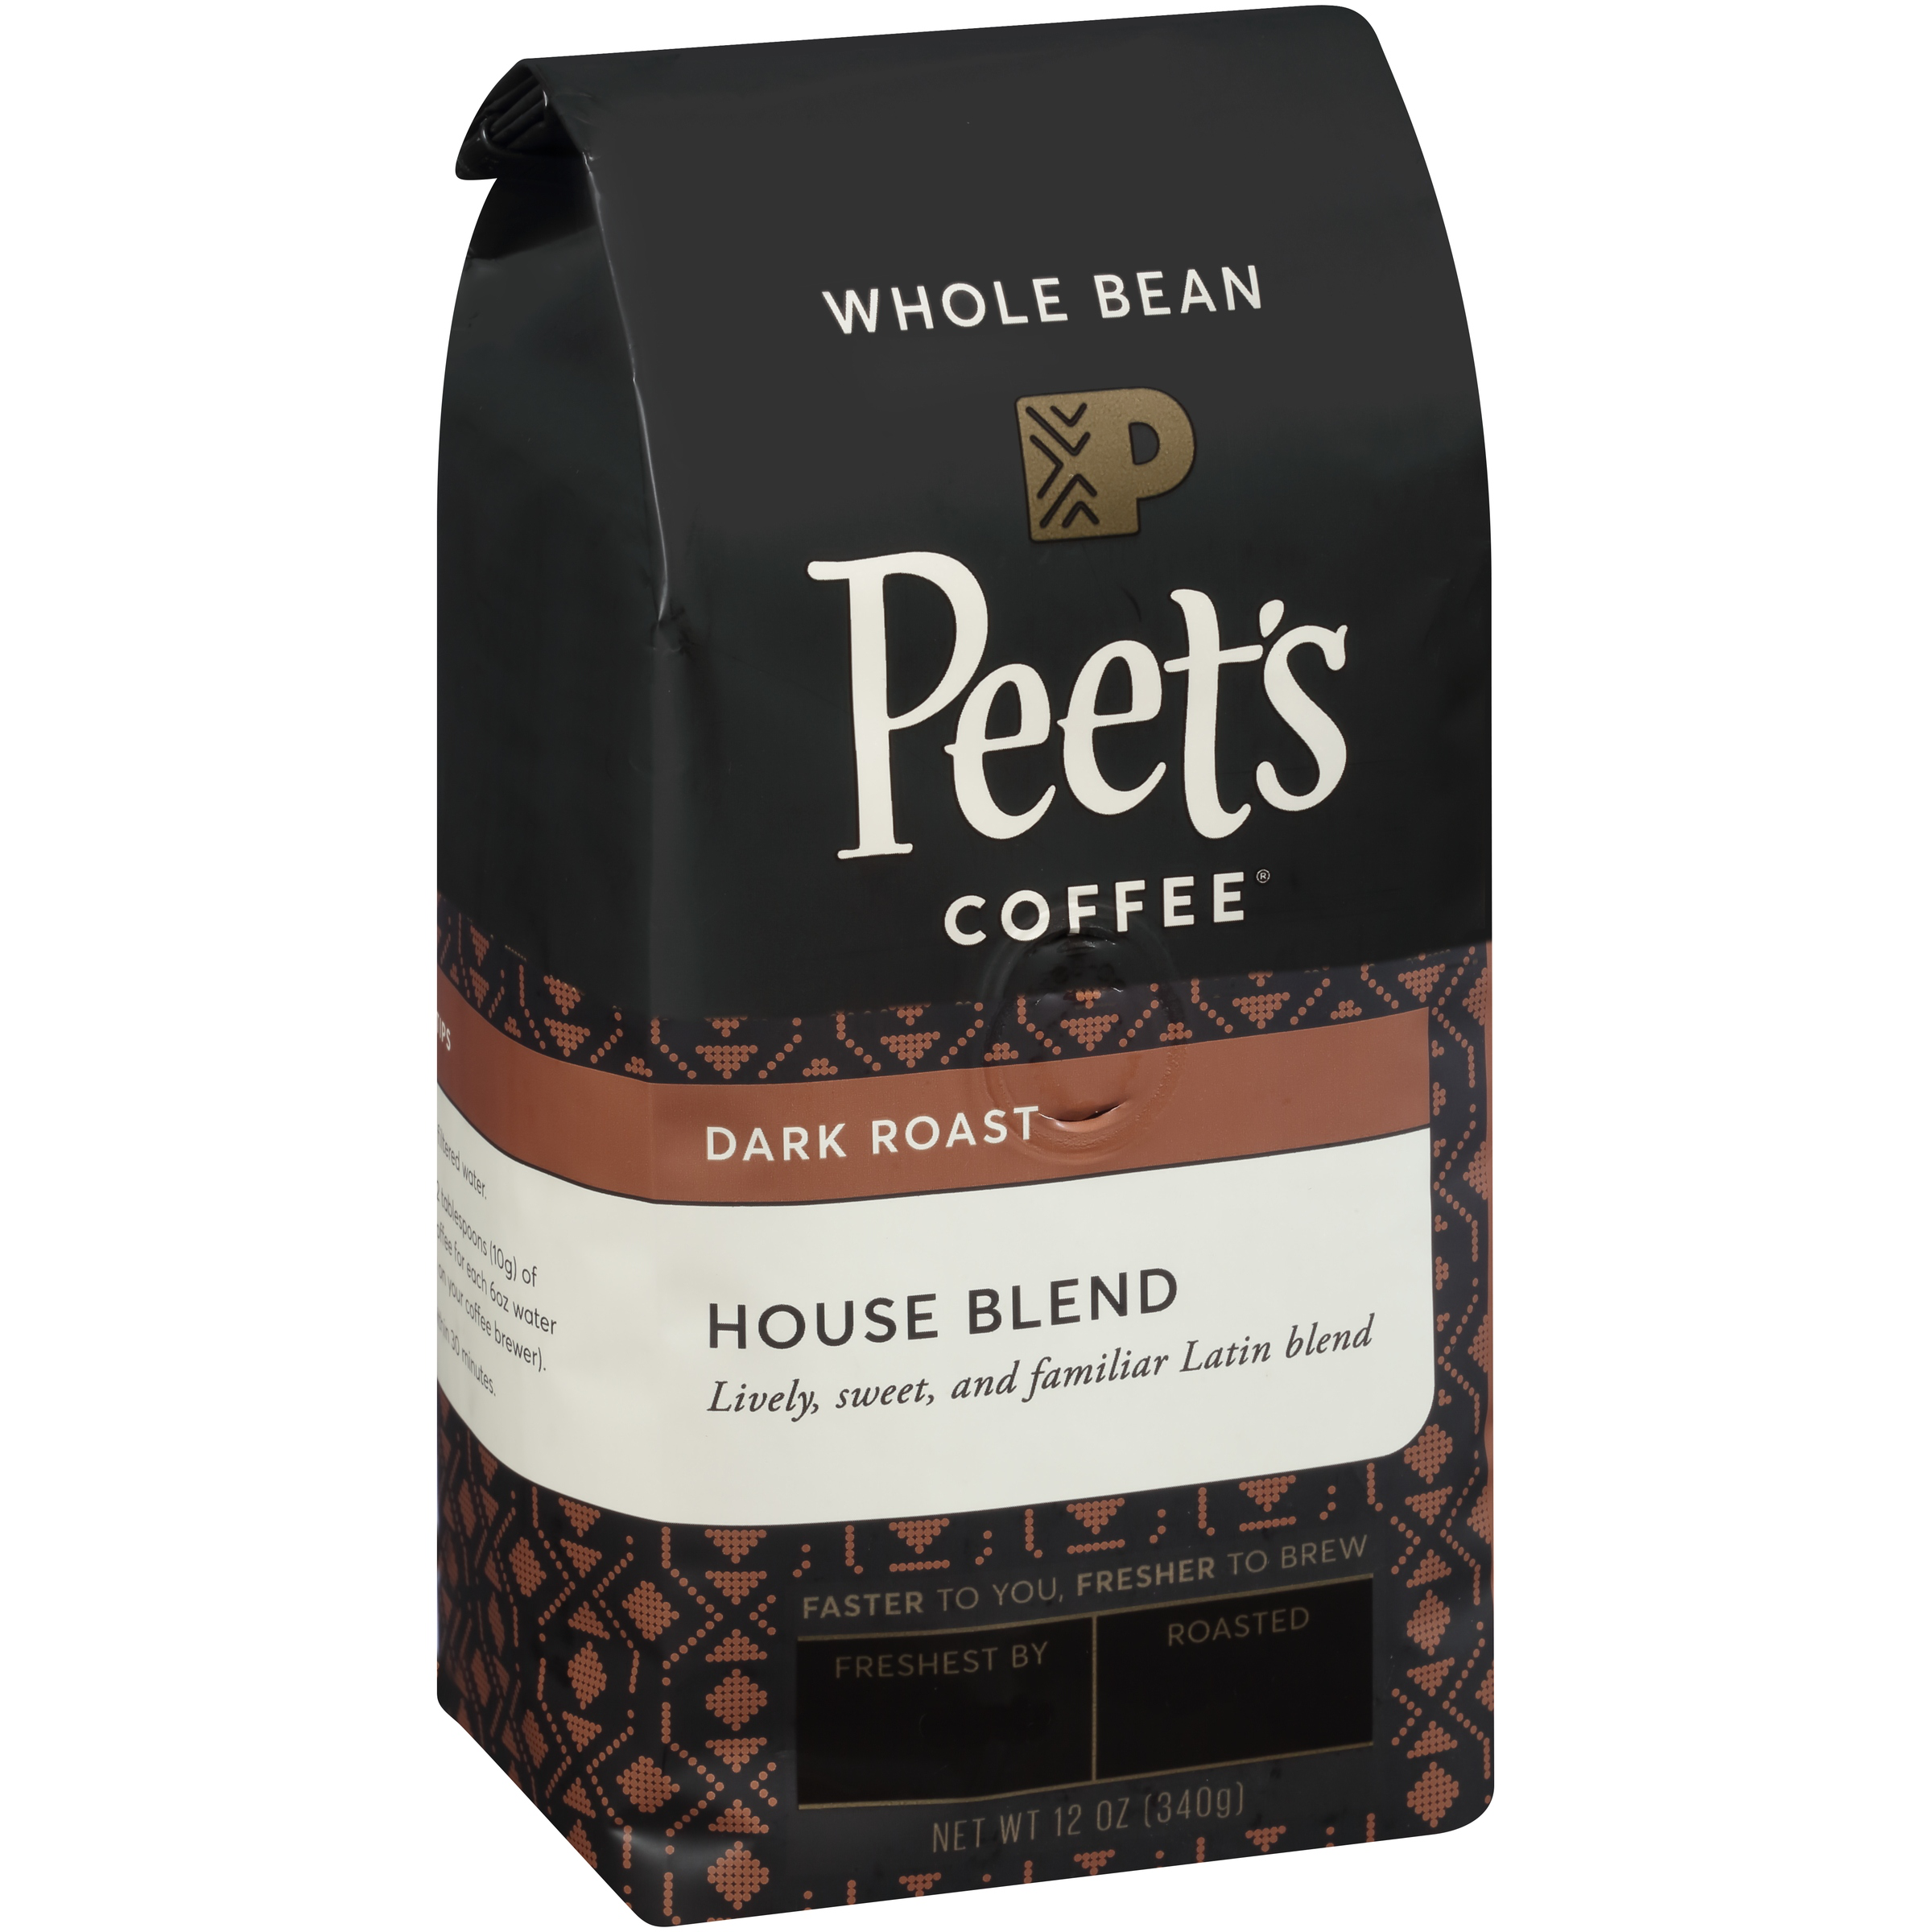

In [78]:
#Opening first image
image = Image.open("Coffee.jpg")
image

In [79]:
#performing inference on above image
prediction('Coffee.jpg', model)

Predicted class is: healthyv1
With a confidence score of:  0.8914023


1

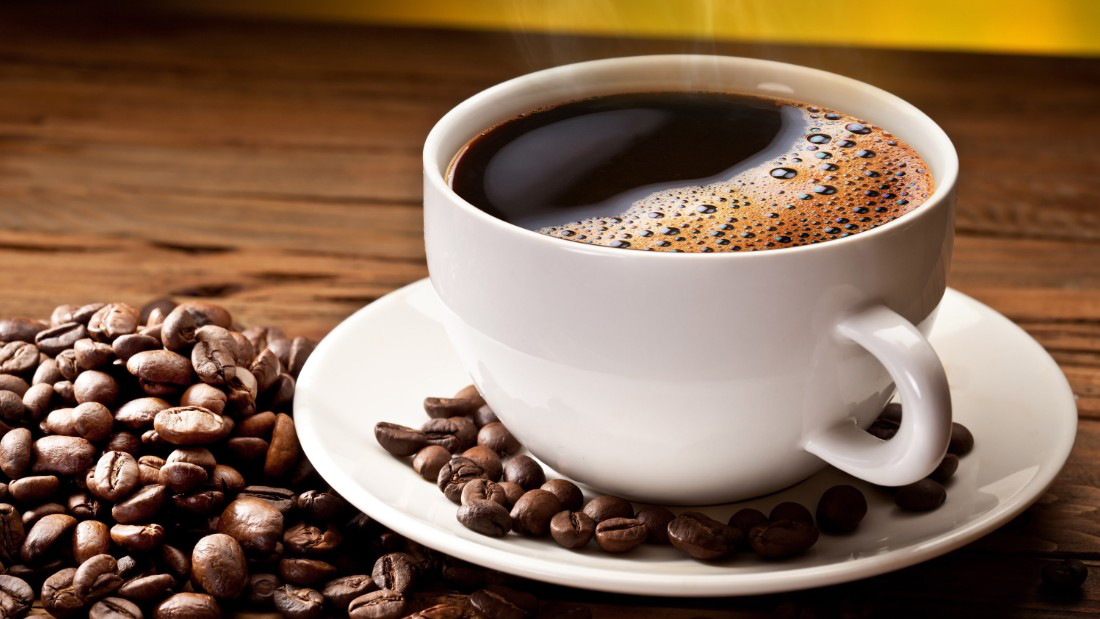

In [80]:
#Opening second image
image = Image.open("Mug.jpg")
image

In [81]:
prediction('Mug.jpg', model)

Predicted class is: lb1compress
With a confidence score of:  0.8258576


2

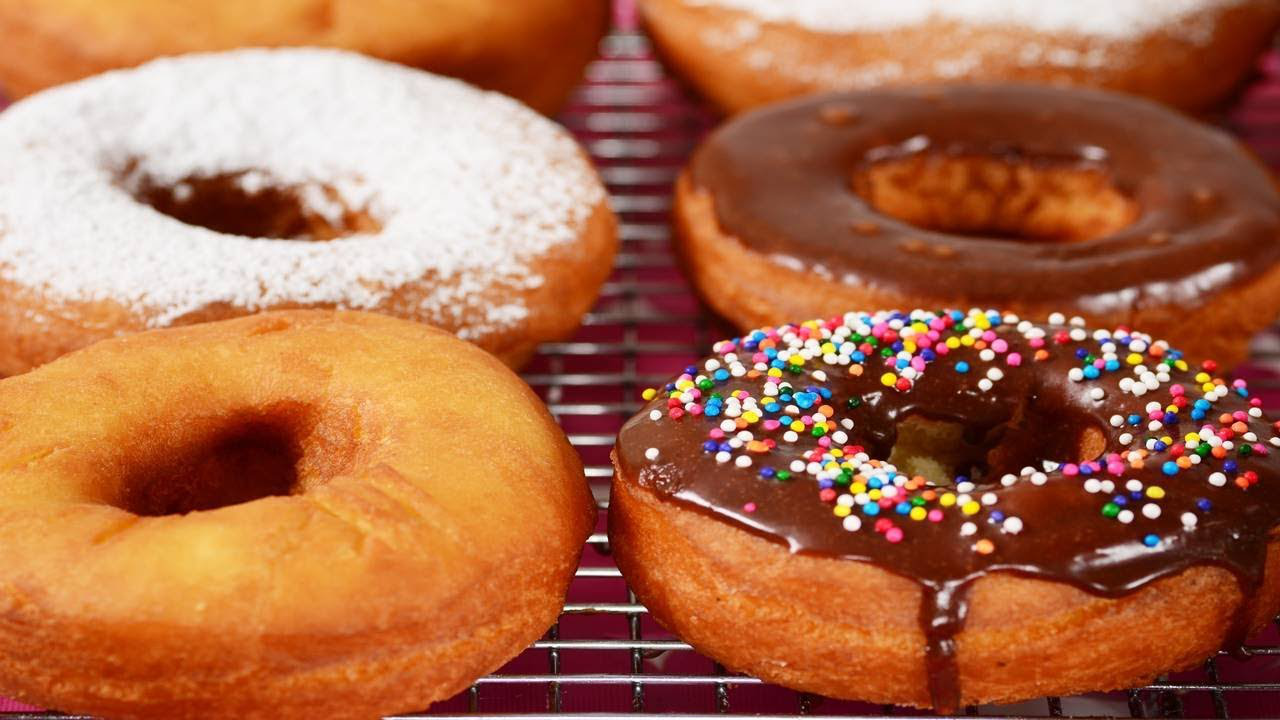

In [82]:
#Opening third image
image = Image.open("Donut.jpg")
image

In [83]:
prediction('Donut.jpg', model)

Predicted class is: lb1compress
With a confidence score of:  0.64136285


2